source https://www.data.gouv.fr/en/datasets/fichier-des-personnes-decedees/
Cette série a pour but récréatif d'analyser les décès enregistrés dans la base insee
les fichiers csv son supposés avoir été téléchargés dans le dossier dat

In [1]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt 
import numpy as np
import datetime
from struct import unpack
import os, sys

# date parser as the date in insee csv is sometimes malformed
def parser(x):
     if len(x) != 8:
         print('Invalid length "{}"'.format(x))
         x = '19000101'
     y, m, d = map(int, unpack('4s2s2s', bytes(x.encode('ascii'))))

    # deal with invalid dates
     y = max(y, 1800)
     d = max(d, 1)
     m = max(min(m, 12), 1)

     if m in [4, 6, 9, 11]:
         d = min(30, d)
     elif m == 2:
         if (y % 4) == 0:
            d = min(d, 29)
         else:
            d = min(d, 28)
     else:
         d = min(d, 31)
     try:
        return datetime.date(y, m, d)
     except Exception as err:
        print(err, y, m, d)
        return datetime.date(y, m, d-1)

def read_fwf(path):
    # date parser
    # handle invalid dates
    print('read', path)
    names=['NOM', 'GENRE', 'DN', 'CP', 'VN', 'PN', 'DD', 'CPD', 'REF']
    df=pd.read_fwf(path, widths=[80,1,8,5,30,30,8,5,9], header=None, names=names, dtype={'NOM':str, 'GENRE': int}).drop(columns=['CP','REF','VN'])
    # doing date parsing while loading causes issues for 1999 so
    # we don the conversion afterward. slower but apparently safer...
    df['DN'] = pd.to_datetime(df['DN'].astype(str).apply(parser), errors='coerce') # some date are invalid -> na
    df['DD'] = pd.to_datetime(df['DD'].astype(str).apply(parser), errors='ignore')
    # calculate the age of death
    df['AGE'] = ((df['DD']-df['DN']).dt.days/365.24)    # precise
    df['AGE'] = df['AGE'].fillna(0)                     # because some dates are na
    df['AGEI'] = df['AGE'].round().astype(int)          # in years
    df['PN'] = df['PN'].fillna('FRANCE')                # no birth country means france
    return df[df['DN'].dt.year > 1850]                  # return valid records with at leat a correct birth year

In [3]:
temp=read_fwf('dat/deces-%s.txt' % 1999)
temp.info()

read dat/deces-1999.txt
Invalid length "0"
Invalid length "0"
<class 'pandas.core.frame.DataFrame'>
Int64Index: 697189 entries, 0 to 697191
Data columns (total 8 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   NOM     697189 non-null  object        
 1   GENRE   697189 non-null  int64         
 2   DN      697189 non-null  datetime64[ns]
 3   PN      697189 non-null  object        
 4   DD      697189 non-null  datetime64[ns]
 5   CPD     697189 non-null  object        
 6   AGE     697189 non-null  float64       
 7   AGEI    697189 non-null  int64         
dtypes: datetime64[ns](2), float64(1), int64(2), object(3)
memory usage: 47.9+ MB


In [4]:
def ly(yr):
    return read_fwf('dat/deces-%s.txt' % yr)

def ly3(yr):
    t1 = read_fwf('dat/deces-%s-t1.txt' % yr)
    t2 = read_fwf('dat/deces-%s-t2.txt' % yr)
    t3 = read_fwf('dat/deces-%s-t3.txt' % yr)
    return t1.append(t2).append(t3)

start = 1991
#os.chdir('/home/francois/projects/deces/')
HDF_NAME = 'dat/%d_2020.hdf' % start
if os.path.exists(HDF_NAME):
    print('reading compressed...')
    tt = pd.read_hdf(HDF_NAME, 'test')
    print('done')
else:
    tt = ly(start)
    for y in range(start+1, 2021):
        tt=tt.append(ly(y))

    print('saving...')
    tt.to_hdf(HDF_NAME, 'test', format='fixed', mode='w', complib='lzo', complevel=3)
    print('done')

reading compressed...
done


In [2]:
import insee
import pandas as pandas
tt = insee.load_db()

reading compressed...OK


In [3]:
tt[(tt['NOM'].str.contains('MOPPERT*')) & (tt['NOM'].str.contains('GASTON'))]

,NOM,GENRE,DN,PN,DD,AGE,AGEI
63210,MOPPERT*GASTON LOUIS/,1,1925-08-19,FRANCE,2020-12-30,95.36743,95


In [6]:
def plot_birth_year(df, path=None):
    year = df['DD'].dt.year.min()
    s1 = df[df['GENRE'] == 1].groupby(df['DN'].dt.year).count()['NOM'].rename('HOMME')
    s2 = df[df['GENRE'] == 2].groupby(df['DN'].dt.year).count()['NOM'].rename('FEMME')

    pd.concat([s1, s2], axis=1)\
        .plot(figsize=(18, 5), grid=True,\
            xticks=range(1900, year, 5), \
            title=f'Date de naissance pour les décès en {year}')
plot_birth_year(tt[tt['DD'].dt.year > 2015])

ValueError: cannot reindex from a duplicate axis

In [ ]:
df=tt
df=df[df['DD'].dt.year > 2015]
df=df.groupby(df['DD'].dt.year).apply(lambda x: x.groupby(['DD', 'GENRE']).count()['NOM'].unstack('GENRE')).rename(columns={1: "HOMME", 2: "FEMME"})
gr=df.groupby('DD').groups
[gr[k] for k in gr.keys()]

In [ ]:
def plot_birth_year(df, path=None):
    df = df.groupby([df['DN'].dt.date, 'GENRE'])\
        .count()['NOM']\
        .unstack('GENRE')\
        .rename(columns={1: "HOMME", 2: "FEMME"})

    return df.fillna(0)
plot_birth_year(tt[tt['DD'].dt.year == 2020])

In [ ]:
tt['DN'].min().date()

In [5]:
tt.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17102458 entries, 0 to 679923
Data columns (total 8 columns):
 #   Column  Dtype         
---  ------  -----         
 0   NOM     object        
 1   GENRE   int64         
 2   DN      datetime64[ns]
 3   PN      object        
 4   DD      datetime64[ns]
 5   CPD     object        
 6   AGE     float64       
 7   AGEI    int64         
dtypes: datetime64[ns](2), float64(1), int64(2), object(3)
memory usage: 1.1+ GB


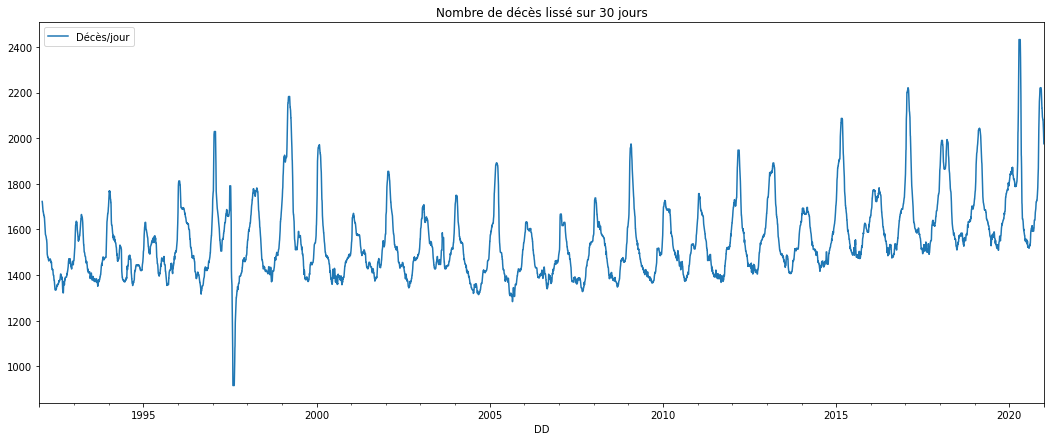

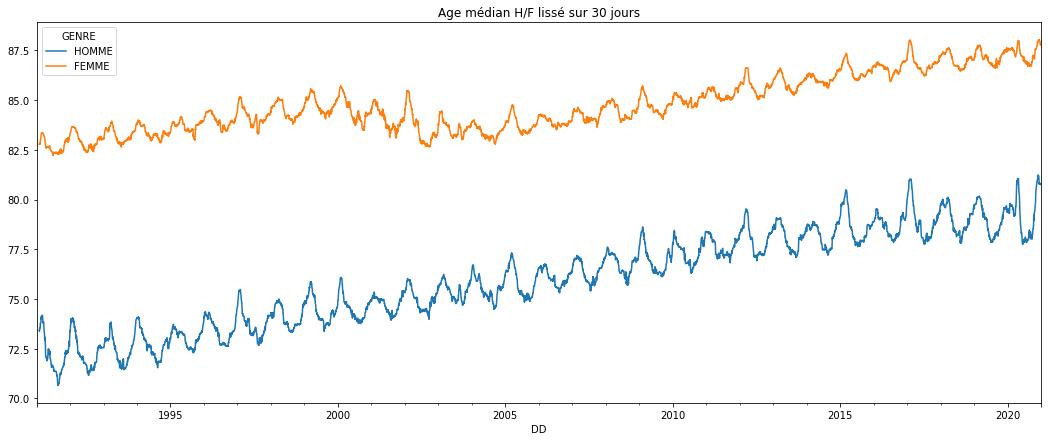

In [10]:
# number of deaths 
def plot_death_per_day(tt):
    SMOOTH=30
    tt[tt['DD'].dt.year > 1991][['DD','NOM']]\
        .groupby(['DD']).count()\
        .rolling(SMOOTH).median()\
        .rename(columns={'NOM':'Décès/jour'})\
        .plot(figsize=(18,7), title='Nombre de décès lissé sur 30 jours')
def plot_death_median_age(tt):
    SMOOTH=30
    # median death age by genre 
    tt[tt['DD'] > '1991-01-01']\
        .groupby(['DD','GENRE'])['AGE'].median()\
        .unstack()\
        .rolling(SMOOTH)\
        .median()\
        .rename(columns={1:"HOMME", 2:"FEMME"})\
        .plot(figsize=(18,7), title='Age médian H/F lissé sur 30 jours')
plot_death_per_day(tt)
plot_death_median_age(tt)

In [4]:
# list of death reports reported late (after january 1991)
def report_late_reports(start):
    print({y:tt[(tt['DD'].dt.year == y)].shape[0] for y in range(start-10, start)})
report_late_reports(1991)

{1981: 510, 1982: 419, 1983: 474, 1984: 427, 1985: 426, 1986: 596, 1987: 659, 1988: 729, 1989: 1117, 1990: 68820}


In [4]:
# make some space froma big table to a table per year
def split_per_year(tt):
    return {y:tt[(tt['DD'].dt.year == y)] for y in range(1991, 2020+1)}
tts = split_per_year(tt)


In [5]:
def print_header():
    cols = ["Année", "Hommes", "Femmes", "Nombre de décès", "Augmentation"]
    print("<table><tr><th></th><th colspan=2></th>")
    for c in cols:
        print(f"<th>{c}</th>", end="")
    print("</tr>")
5
def report_stats(data, start):
    # display some stats per year
    def print_row(df, y):
        #df = df[df['AGE'] < 75]
        print(f"<tr><td>{y}</td>",end="")
        # show the median death age for each gender
        print(f"<td>{round(df[df['GENRE']==1]['AGE'].median(),1)}</td>",end="")
        print(f"<td>{round(df[df['GENRE']==2]['AGE'].median(),1)}</td>",end="")
        print(f"<td>{df.shape[0]}</td>",end="")
        return df.shape[0]

    prev = None
    print_header()
    for y in range(start, 2021):
        n = print_row(data[y], y)
        if prev:
            print(f"<td>{round(100*(n/prev-1.0), 2)}</td>",end="")
        else:
            print("<td></td>",end="")
        print("</tr>")
        prev = n
    print("</table>")
report_stats(tts, 1991)

<table><tr><th></th><th colspan=2></th>
<th>Année</th><th>Hommes</th><th>Femmes</th><th>Nombre de décès</th><th>Augmentation</th></tr>
<tr><td>1991</td><td>72.1</td><td>82.7</td><td>537404</td><td></td></tr>
<tr><td>1992</td><td>72.2</td><td>83.0</td><td>533796</td><td>-0.67</td></tr>
<tr><td>1993</td><td>72.6</td><td>83.3</td><td>547378</td><td>2.54</td></tr>
<tr><td>1994</td><td>72.7</td><td>83.4</td><td>536766</td><td>-1.94</td></tr>
<tr><td>1995</td><td>73.1</td><td>83.8</td><td>545753</td><td>1.67</td></tr>
<tr><td>1996</td><td>73.5</td><td>84.0</td><td>559409</td><td>2.5</td></tr>
<tr><td>1997</td><td>73.8</td><td>84.2</td><td>552307</td><td>-1.27</td></tr>
<tr><td>1998</td><td>74.2</td><td>84.5</td><td>571022</td><td>3.39</td></tr>
<tr><td>1999</td><td>74.5</td><td>84.9</td><td>603401</td><td>5.67</td></tr>
<tr><td>2000</td><td>74.6</td><td>84.8</td><td>550183</td><td>-8.82</td></tr>
<tr><td>2001</td><td>74.8</td><td>84.1</td><td>550783</td><td>0.11</td></tr>
<tr><td>2002</td><t

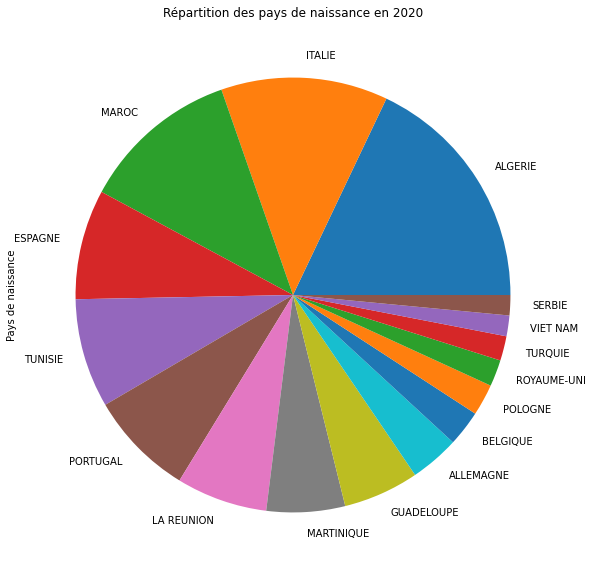

In [8]:
def plot_per_country_birth(tts, y):
    t=tts[y]
    t[t['PN']!='FRANCE']\
        .groupby(['PN'])\
        .count()['NOM']\
        .rename('Pays de naissance')\
        .sort_values(ascending=False)\
        .head(16)\
        .plot.pie(figsize=(10,10), title='Répartition des pays de naissance en 2020')
plot_per_country_birth(tts, 2020)

<AxesSubplot:title={'center':'Age de décès homme de 2014 à 2020'}, xlabel='AGEI'>

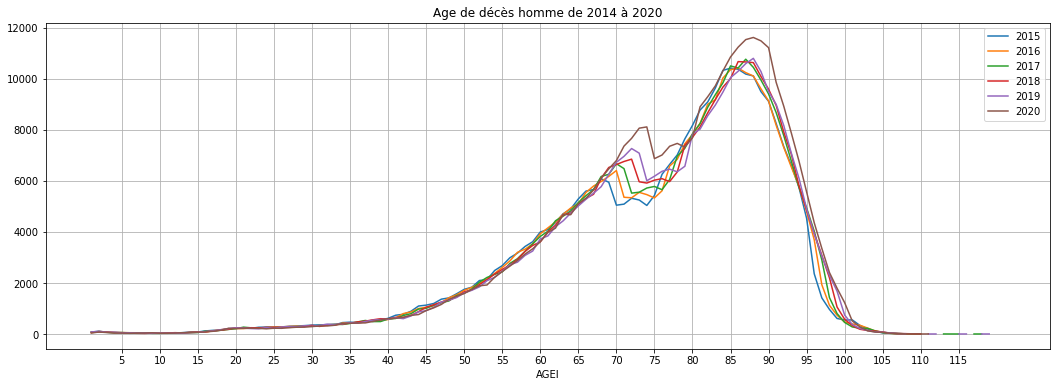

In [10]:
a, n=2014, 7
tts1 =  {k:tts[k] for k in tts if a < int(k) < a+n}
df = [t[(t['AGE']>1) & (t['GENRE'] == 1)].groupby('AGEI').count()['NOM'] for t in tts1.values()]
df = pd.concat(df, axis=1)
df.columns = tts1.keys()
df.plot(figsize=(18,6), grid=True, xticks=range(5,120,5), title='Age de décès homme de {} à {}'.format(a, a+n-1))

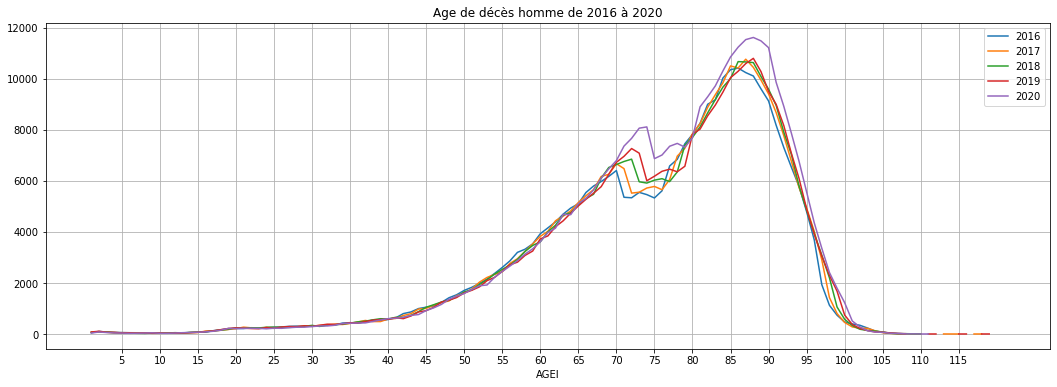

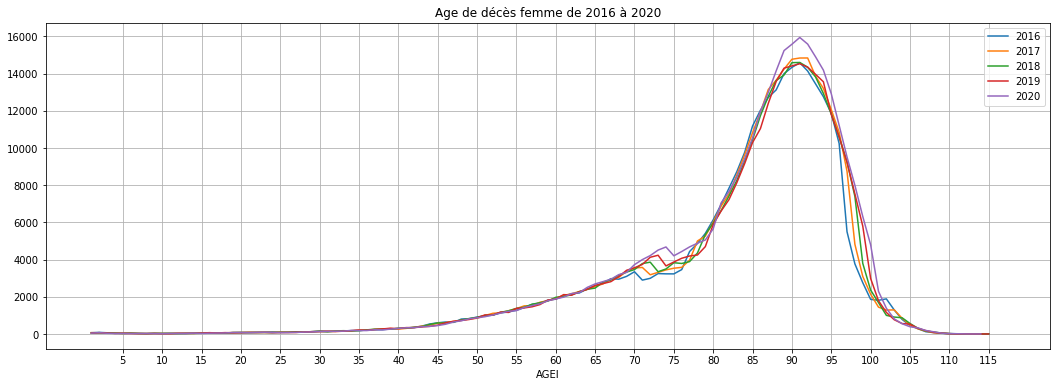

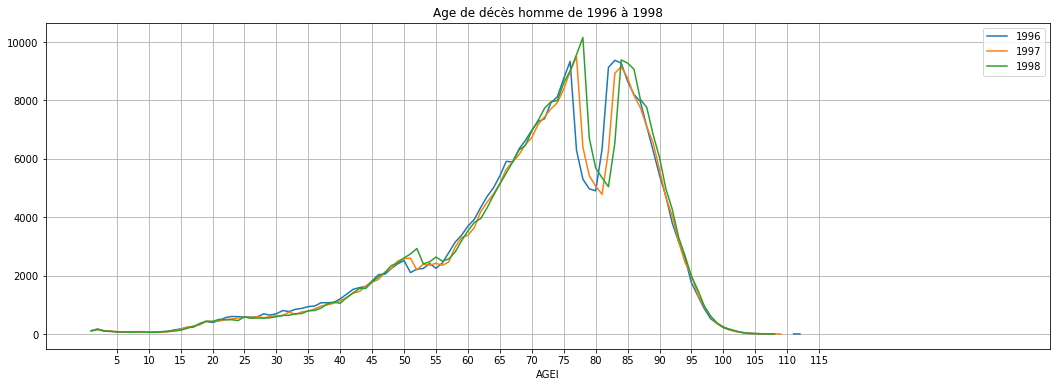

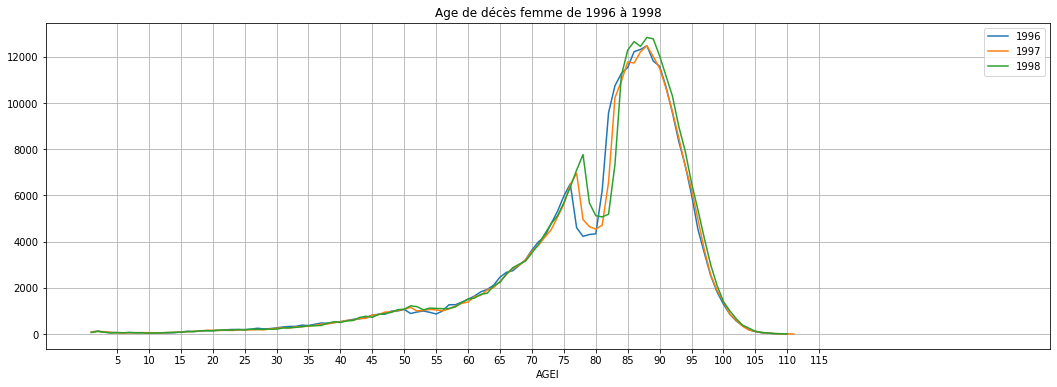

In [12]:
def plot_death_age_hf(tt, a, n):
    tts1 =  {k:tts[k] for k in tts if a < int(k) < a+n}
    df = [t[(t['AGE']>1) & (t['GENRE'] == 1)].groupby('AGEI').count()['NOM'] for t in tts1.values()]
    df = pd.concat(df, axis=1)
    df.columns = tts1.keys()
    df.plot(figsize=(18,6), grid=True, xticks=range(5,120,5), title='Age de décès homme de {} à {}'.format(a+1, a+n-1))
    df = [t[(t['AGE']>1) & (t['GENRE'] == 2)].groupby('AGEI').count()['NOM'] for t in tts1.values()]
    df = pd.concat(df, axis=1)
    df.columns = tts1.keys()
    df.plot(figsize=(18,6), grid=True, xticks=range(5,120,5), title='Age de décès femme de {} à {}'.format(a+1, a+n-1))

plot_death_age_hf(tt, 2015,6)
plot_death_age_hf(tt, 1995,4)

In [61]:
* Age de décès plus probable de 1991 à 220

SyntaxError: invalid syntax (<ipython-input-61-4a07fccfc631>, line 1)

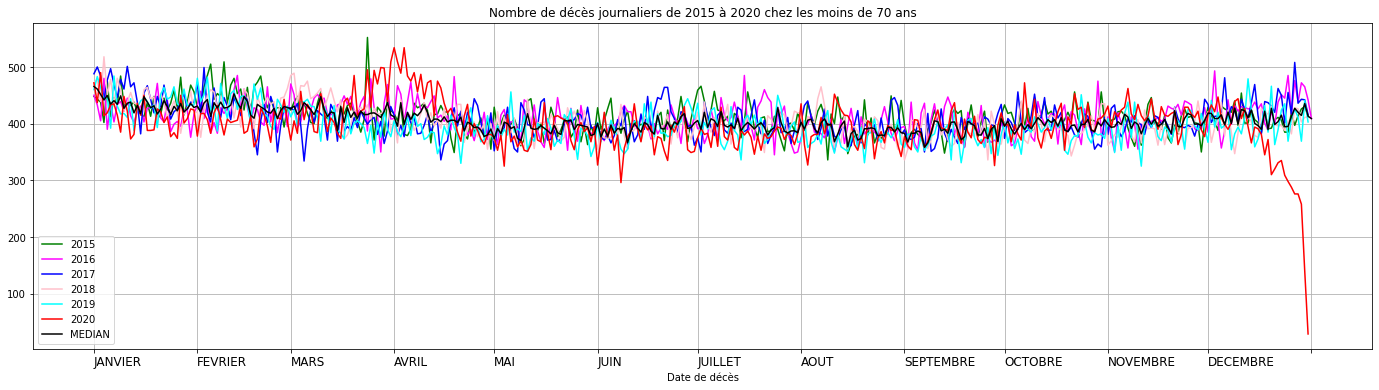

In [13]:
def plot_deaths_in_year(start, n):
    years = range(start , start+n+1)
    colors = ['green', 'magenta', 'blue',  'pink', 'cyan', 'red'] + ['black']
    import itertools
    colors = list(itertools.islice(itertools.cycle(colors), len(years)))+['black']

    agemax = 70
    temp =  {y:tts[y][tts[y]['AGE'] <= agemax][['NOM', 'DD']] for y in years}
    df = [t.groupby(t['DD'].dt.dayofyear).count()['NOM'] for t in temp.values()]
    df = pd.concat(df, axis=1)
    df['MEAN'] = df.median(axis=1)
    df.columns = list(temp.keys())+['MEDIAN']
    ax = df.plot(figsize=(24,6), grid=True, xticks=np.cumsum([1, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]), color=colors,\
        title=f'Nombre de décès journaliers de {years[0]} à {years[-1]} chez les moins de {agemax} ans')
    ax.set_xticklabels(['JANVIER','FEVRIER','MARS','AVRIL', 'MAI', 'JUIN', 'JUILLET', 'AOUT', 'SEPTEMBRE', 'OCTOBRE', 'NOVEMBRE', 'DECEMBRE', ''], fontdict={'fontsize': 12,  'horizontalalignment': 'left'})
    ax.set_xlabel('Date de décès')
    temp=None
plot_deaths_in_year(2015, 5)

**_Age de décès plus probable de 1991 à 2020_**

In [63]:
df=tt[tt['DD'].dt.year >= 1991]
df['AGEX'] = ((df['AGE']*10).astype(int)).astype(float)/10
dfh=df[df['GENRE']==1][['DD', 'NOM', 'AGEX']].groupby(['DD', 'AGEX']).count() 
dfh=dfh.groupby(['DD']).apply(lambda x: x.sort_values('NOM').idxmax()[0][1])
dff=df[df['GENRE']==2][['DD', 'NOM', 'AGEX']].groupby(['DD', 'AGEX']).count()
dff=dff.groupby(['DD']).apply(lambda x: x.sort_values('NOM').idxmax()[0][1])
pd.concat([dfh,dff], axis=1).rename(columns={0:'HOMME', 1:'FEMME'})\
    .rolling(300).median()\
    .plot(figsize=(18,8))


In [59]:
pd.concat([dfh,dff], axis=1)

,0,1
DD,,
1991-01-01,83.3,87.8
1991-01-02,81.6,85.8
1991-01-03,62.1,86.9
1991-01-04,81.9,89.1
1991-01-05,84.2,84.6
...,...,...
2020-12-26,87.9,90.5
2020-12-27,80.7,92.9
2020-12-28,82.9,90.7


In [50]:
df2=df[['DD', 'NOM', 'AGEX']].groupby(['DD', 'AGEX']).count()\
    .groupby(['DD'])\
    .apply(lambda x: x.idxmax()\
    .values[0][1])\
    .rolling(300).median()\
    .plot(figsize=(18,8))

<AxesSubplot:xlabel='DD'>

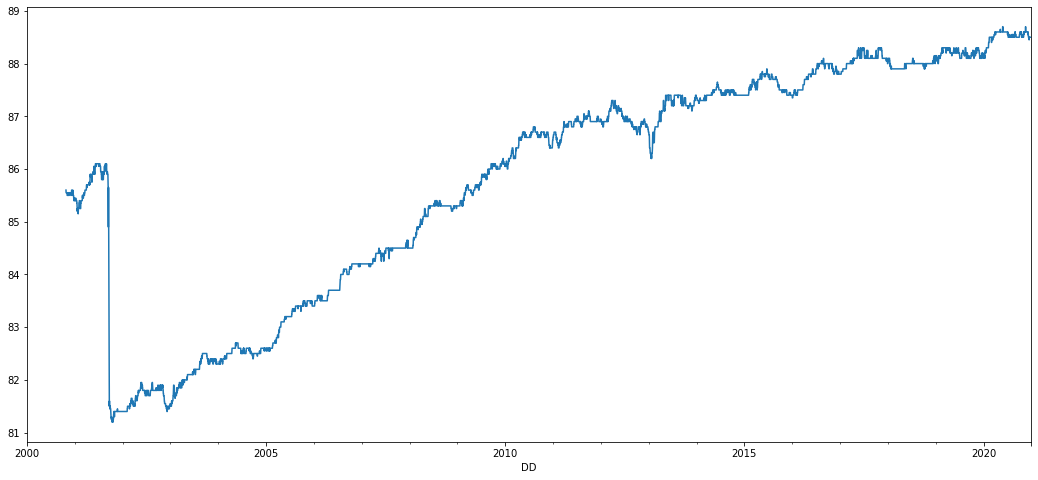

In [52]:
df2.groupby(['DD']).apply(lambda x: x.idxmax().values[0][1]).rolling(300).median().plot(figsize=(18,8))

In [137]:
df2.sort_values(by='NOM')

NOM
DD         AGEI     
2010-11-18 34      1
2009-08-09 27      1
           32      1
           35      1
           37      1
...              ...
2003-08-11 90    150
2003-08-12 90    152
           83    158
2003-08-11 89    164
2003-08-13 90    165

[644476 rows x 1 columns]

In [12]:
for k in tts:
    t=tts[k]
    t['BY']=t['DN'].dt.year 
    t['BDY']=t['DN'].dt.dayofyear
tts[2019]

,NOM,GENRE,DN,PN,DD,CPD,AGE,AGEI,BY,BDY
0,LAIBE*SUZANNE/,2,1926-01-11,FRANCE,2019-01-29,01004,93.051144,93,1926,11
1,MONTIFRET*DOMINIQUE/,1,1962-07-23,FRANCE,2019-01-11,01004,56.472456,56,1962,204
2,MICHAUD*GILBERT/,1,1931-05-12,FRANCE,2019-01-19,01004,87.693024,88,1931,132
3,JOUD*GERARD/,1,1945-01-18,FRANCE,2019-01-20,01004,74.006133,74,1945,18
11,PITOLLAT*GERARD MARIUS/,1,1945-01-15,FRANCE,2019-01-01,01004,73.962326,74,1945,15
...,...,...,...,...,...,...,...,...,...,...
679862,MOHAMED*HAISSA/,2,1940-03-24,LA REUNION,2019-12-18,99390,79.736612,80,1940,84
679877,ABDI*KAMEL/,1,1973-09-02,FRANCE,2019-11-01,99352,46.164166,46,1973,245
679882,DESCHAMPS*JEAN CLAUDE JACQUES/,1,1947-01-27,FRANCE,2019-12-08,99140,72.864418,73,1947,27
679886,LEVY*GRAZIANO CLEMENT/,1,1953-12-15,LIBYE,2019-12-30,99127,66.041507,66,1953,349


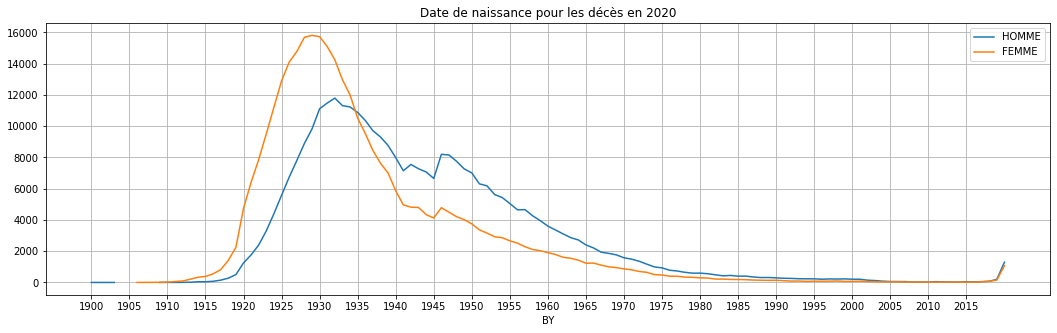

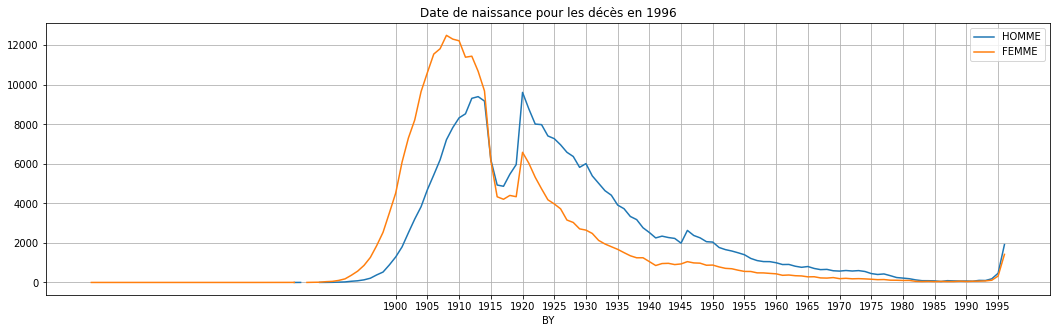

In [13]:
def plot_birth_year(tts, year):
    t=tts[year]
    s1=t[t['GENRE']==1].groupby('BY').count()['NOM'].rename('HOMME')
    s2=t[t['GENRE']==2].groupby('BY').count()['NOM'].rename('FEMME')

    pd.concat([s1,s2], axis=1).plot(figsize=(18,5),grid=True,xticks=range(1900,year,5),title='Date de naissance pour les décès en {}'.format(year))
plot_birth_year(tts, 2020)
plot_birth_year(tts, 1996)

<AxesSubplot:>

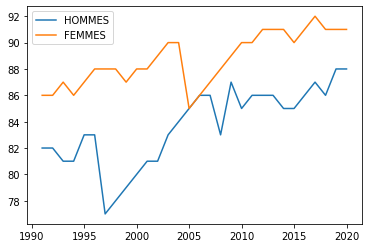

In [14]:
def death_age(x, g):
    xx=x[(x['AGEI'] > 0) & (x['GENRE'] == g)].drop(columns=['GENRE', 'DN', 'DD', 'BDY', 'PN', 'AGE', 'CPD', 'BY']).groupby('AGEI').count()
    age=xx.max()[0]
    xxx=xx.reset_index()
    return xxx[xxx['NOM'] == age].reset_index()['AGEI'].at[0]
years=range(1991, 2021)
men=[death_age(tts[y], 1) for y in years]
women=[death_age(tts[y], 2) for y in years]
df=pd.DataFrame({'HOMMES':men, 'FEMMES':women}, years)
df.plot()
# les chutes sont causées par la présence de deux pics pour les personnes nées pendant la guerre 14-18 voir la courbe de décès en fonction de l'age

In [19]:
tts

ABRIEUX*ANDRE/      1 1927-10-06   ALGERIE   
 679714               BOUCHAGOUR*EL AZIZI/      1 1954-11-07   ALGERIE   
 
                DD    CPD         AGE  AGEI    BY  BDY  
 242    2008-01-14  62758  104.175337   104  1903  316  
 349    2008-01-07  75115   76.875479    77  1931   53  
 362    2008-01-15  99131   85.617676    86  1922  155  
 376    2008-01-09  99131   48.442120    48  1959  213  
 419    2008-01-02  99131   95.118278    95  1912  325  
 ...           ...    ...         ...   ...   ...  ...  
 601617 2008-12-18  83042   81.609353    82  1927  131  
 611663 2008-06-29  99138   93.434454    93  1915   23  
 679398 2008-07-01  99401   89.664330    90  1918  306  
 679543 2008-08-01  99352   80.823568    81  1927  279  
 679714 2008-10-23  99352   53.961779    54  1954  311  
 
 [550123 rows x 10 columns],
 2009:                                 NOM  GENRE         DN             PN  \
 62                   SANNA*ANTONIO/      1 1934-08-03         ITALIE   
 63       V

In [18]:
tt['DEP']= tt['CPD'].astype(str).apply(lambda xs: xs[:2])
tt['DDS'] = tt['DD'].apply(lambda dt: datetime.datetime.strftime(dt, "%Y%m"))
tt['DDY'] = tt['DD'].apply(lambda dt: datetime.datetime.strftime(dt, "%Y%m"))

TypeError: 'NoneType' object is not subscriptable

In [19]:
tt['DD'].apply(lambda dt: dt.year)
tt

TypeError: 'NoneType' object is not subscriptable

In [18]:
tt[tt['DD'].dt.year >= 1991].groupby(['DDS','DEP'])['NOM'].count() #.unstack().plot(figsize=(18,250), subplots=True)

TypeError: 'NoneType' object is not subscriptable

In [19]:
#same
SMOOTH=500
tt[(tt['DD'] > '1991-01-01') & (tt['GENRE'] == 2)].groupby(['DD','DEP'])['AGE'].median().unstack().rolling(SMOOTH).median().plot(figsize=(18,300), subplots=True)

TypeError: 'NoneType' object is not subscriptable

In [20]:
tt[(tt['DD'] > '1991-01-01') & (tt['GENRE'] == 2)].groupby(['DD','DEP'])['NOM'].count().unstack().fillna(0).plot(figsize=(18,300), subplots=True)

TypeError: 'NoneType' object is not subscriptable

In [21]:
tt[(tt['DD'] > '1991-01-01') & (tt['GENRE'] == 2)].groupby([tt['DD'],tt['DEP']])['NOM'].count()

TypeError: 'NoneType' object is not subscriptable

In [ ]:
tt